# 前準備

In [1]:
# 用いるライブラリのインポート
import hashlib

import numpy as np
import polars as pl
import polars.selectors as cs
pl.Config(fmt_str_lengths = 50, tbl_cols = 100, tbl_rows = 100)
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
%matplotlib inline

import arviz as az
import pymc as pm
import pytensor.tensor as pt
az.style.use("arviz-darkgrid")

import joblib

URL_CH2_LOGDATA = "https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch2_logdata.csv"
URL_LENTA_DATA = "https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/lenta_dataset.csv"

# pythonによるプッシュ通知施策効果の検証

#### プログラム2.4 A/B テストによるプッシュ通知施策の効果検証

前準備：データの取得と確認

In [2]:
# データの取得
df = pl.read_csv(URL_LENTA_DATA)
# 共変量がバランスしているかを調べる
df_balance_test = (
    df.group_by("is_treatment")
    .agg([
        pl.mean("food_share_15d").round(decimals = 3),
        pl.mean("age").round(decimals = 3),
        pl.mean("is_women").round(decimals = 3),
    ])
)
display(df_balance_test)

is_treatment,food_share_15d,age,is_women
i64,f64,f64,f64
0,0.346,43.579,0.619
1,0.349,43.803,0.63


書籍の回帰分析

In [3]:
result = smf.ols(formula = "response_att ~ is_treatment", data = df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           response_att   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.890
Date:                Sat, 15 Jun 2024   Prob (F-statistic):            0.00497
Time:                        09:53:36   Log-Likelihood:                -12692.
No. Observations:               50000   AIC:                         2.539e+04
Df Residuals:                   49998   BIC:                         2.541e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1024      0.003     36.412      0.000       0.097       0.108
is_treatment     0.0091      0.003      2.809      0.005       0.003       0.015
==============================================================================
Omnibus:                    23649.035   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            90406.287
Skew:                           2.505   Prob(JB):                         0.00
Kurtosis:                       7.277   Cond. No.                         3.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ベイズ線形回帰\
顧客が来訪するか否かは、確率 $p$ のベルヌーイ分布に従う確率変数と見て分析を行う。\
目的変数 $y$ = ```response_att```、 特徴量 $W_i$ = ```is_treatment``` として一般化線形回帰分析を行う。

$$
\begin{align}
y &\sim \mathcal{Be} \bigl( p \bigr)\\
p &= \beta _0 + \tau W_i\\
\beta _0 &\sim \mathcal{N} \bigl( 0.5 , 1)\\
\tau &\sim \mathcal{N} \bigl( 0 , 1)\\
\end{align}
$$

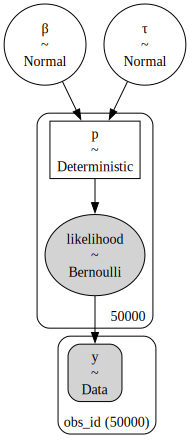

In [4]:
# nutpie サンプラーを使用する場合、with ブロックの前に特徴量を定義する
# with ブロック内で定義した変数を使って計算するとエラーになる(Rustの所有権関係?)
Wi = df["is_treatment"].to_numpy()

with pm.Model() as model:
    # Define priors
    β = pm.Normal("β", mu = 0, sigma = 10)
    τ = pm.Normal("τ", mu = 0, sigma = 10)

    # Data
    y = pm.Data("y", df["response_att"].to_numpy(), dims = "obs_id")

    # Deterministic
    p = pm.Deterministic("p", pm.math.sigmoid(β + τ * Wi))

    # Define likelihood
    pm.Bernoulli("likelihood", p = p, observed = y)

# モデル構造の可視化
pm.model_to_graphviz(model)

In [5]:
with model:
    # 乱数シードの初期化
    RANDOM_SEED = 1192
    rng = np.random.default_rng(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    # 事後分布の生成
    idata = pm.sample(draws = 1000, tune = 1000, chains = 4, target_accept = 0.9, random_seed = rng, nuts_sampler = "nutpie")

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.62,7
,2000,0,0.56,7
,2000,0,0.56,15
,2000,0,0.54,9


array([<Axes: title={'center': 'β'}>, <Axes: title={'center': 'τ'}>],
      dtype=object)

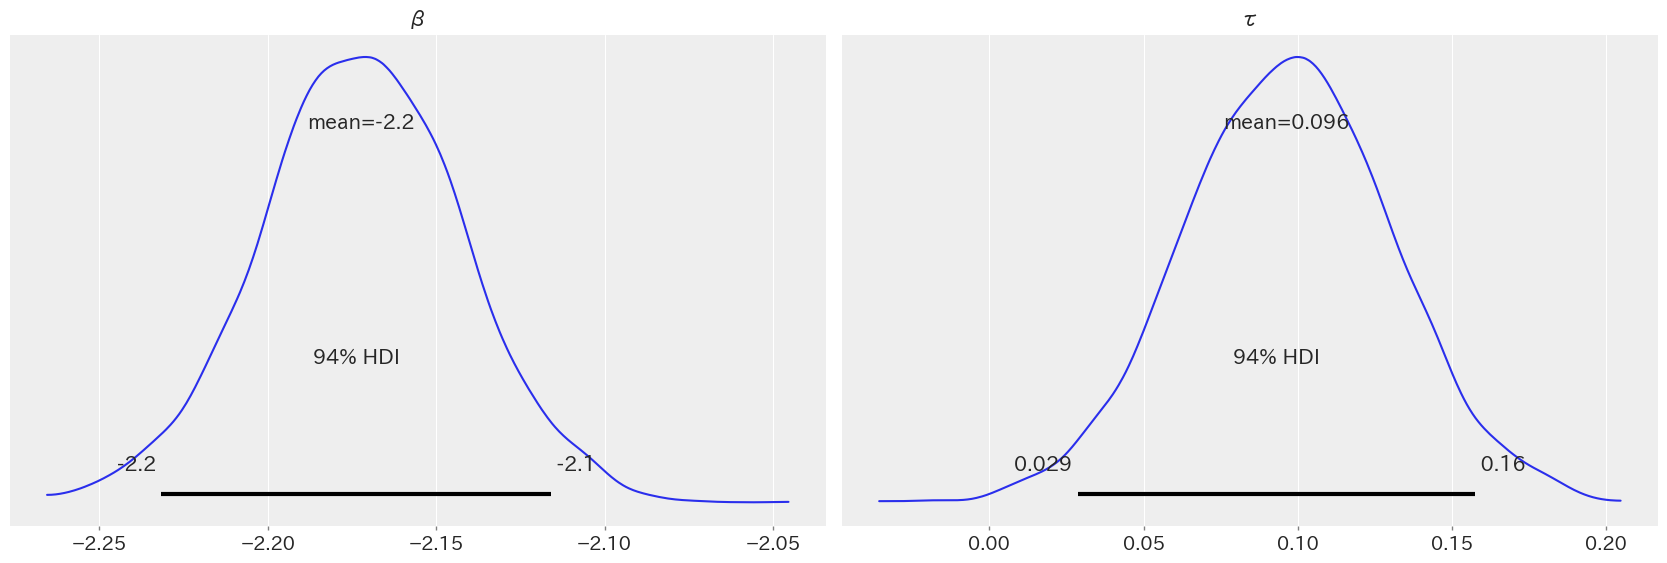

In [20]:
# サンプリングトレースの可視化
# パラメータの事後分布を描画する
az.plot_posterior(idata, var_names = ["β", "τ"])

# パラメータの事後分布と推移を描画する。とてつもなく遅い。
# ディスカッションが作られるくらい遅い
# https://discourse.pymc.io/t/arviz-plot-trace-runs-forever-doesnt-complete/11164
#az.plot_trace(idata)

# その他の描画関数
# https://python.arviz.org/en/stable/api/plots.html

In [21]:
# モデルの保存
# データ容量 70 MB
#joblib.dump(idata, "chapter 2 idata.pkl", compress = 9)

['chapter 2 idata.pkl']

In [22]:
# モデルの読込み
#idata = joblib.load("chapter 2 idata.pkl")

In [23]:
### モデル評価
summary = az.summary(
    idata,
    var_names = ["β", "τ"]
)
display(summary)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,-2.172,0.030,-2.232,-2.116,0.001,0.001,973.0,940.0,1.0
τ,0.096,0.034,0.029,0.157,0.001,0.001,993.0,1024.0,1.0


In [24]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

# パラメータの推定値
means = summary["mean"]
β_hat = means["β"]
τ_hat = means["τ"]

# 確率
base_probability = sigmoid(β_hat) * 100
treated_probability = sigmoid(β_hat + τ_hat) * 100
print("施策無しの来店確率:", np.round(base_probability, decimals = 2), "%")
print("施策有の来店確率:", np.round(treated_probability, decimals = 2), "%")
print("施策効果:", np.round(treated_probability - base_probability, decimals = 2), "point")

施策無しの来店確率: 10.23 %
施策有の来店確率: 11.15 %
施策効果: 0.92 point


In [25]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sat Jun 15 2024

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.25.0

pytensor: 2.22.1

pymc               : 5.15.1
japanize_matplotlib: 1.1.3
arviz              : 0.18.0
polars             : 0.20.31
pytensor           : 2.22.1
statsmodels        : 0.14.2
joblib             : 1.4.2
matplotlib         : 3.8.4
seaborn            : 0.13.2
numpy              : 1.26.4

Watermark: 2.4.3

